# Data sourcing and preprocessing

As with any other Machine Learning application, the first step is to get and prepare the data for our models.
This notebook will focus in doing precisely this, explaining step by step the data obtained and using graphs to
 visualize these features. At the end of the notebook, we prepare clean data sets,
 which will be stored in the `data/` folder.


### What will we do?

Our goal will be to obtain and process the data, specifically:
- Use Quandl and yfinance to **source stock market, currencies and Bitcoin fundamentals.**
- **Calculate technical analysis indicators**, such as simple moving averages, relative strength index (RSI),
stochastic RSI, cumulated standard deviation and distance to prices.
- **Label data** necessary to provide trading signal predictions later. These labels were selected according to the
historical distribution of daily Bitcoin returns.
- **Create different plots, histograms and heatmaps** to have an initial feeling of how the features look like.
- **Join and clean up the datasets**
- **Store data** with and without transformations to feed in the relevant Azure service with appropiate data.

## Importing dependencies and utility functions

As described in our project proposal, we will first use historical data from financial data as our data inputs.
For this, we are going to use `yfinance` library, that scrapes this data from Yahoo Finance,
returning it as a pandas dataframe, which will facilitate most of this work, and also we'll use `quandl`.

However, since the tickers mostly have special signs and we want to create an object for each ticker historical data,
I'll first get the data and clear the name to get an appropiate object.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np
import yfinance as yf

# import cufflinks as cf
from matplotlib import pyplot as plt

from data_utils.transformations import lower_clean_name, change_name, min_max_scaler, back_min_max, \
    standardizer, back_standardizer, get_log_cumulative

from data_utils.settings import ma_values, rsi_values, ticker_list

## Data Sourcing

In [2]:
signs = ['=','^','-','.']
labels = [lower_clean_name(word,signs) for word in ticker_list]
changed_labels = [change_name(x) for x in labels]

for x in range(len(labels)):
    print(labels[x] +' = '+changed_labels[x])

ticker_concat = " ".join(ticker_list)
ohlcv = yf.download(ticker_concat, start="2008-01-01", threads=False)
tickers = yf.download(ticker_concat, start="2008-01-01", group_by='tickers')

gspc = spy
ixic = nasdaq
gcf = gold
sif = silver
clf = crude oil
tnx = rates
btcusd = btc
n225 = nikkei
ftse = ftse
eurusdx = euro
000001ss = shangai
hsi = hsi
[*********************100%***********************]  12 of 12 completed
[*********************100%***********************]  12 of 12 completed


In [3]:
ohlcv.tail()

Adj Close                                                  \
              000001.SS       BTC-USD       CL=F  EURUSD=X         GC=F   
Date                                                                      
2022-02-09  3479.949951  44338.796875  89.660004  1.142126  1835.199951   
2022-02-10  3485.909912  43565.113281  89.879997  1.142152  1836.199951   
2022-02-11  3462.949951  42407.937500  93.099998  1.141553  1840.800049   
2022-02-12          NaN  42244.468750        NaN       NaN          NaN   
2022-02-13          NaN  42028.769531        NaN       NaN          NaN   

                                                                             \
                 SI=F        ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                                          
2022-02-09  23.336000  7643.399902  4587.180176  24829.990234  14490.370117   
2022-02-10  23.518999  7672.399902  4504.080078  24924.349609  14185.639648   
2022-02-11  23.365999  7661.000000  4418.640137  24906.660156  13791.150391   
2022-02-12        NaN          NaN          NaN           NaN           NaN   
2022-02-13        NaN          NaN          NaN           NaN           NaN   

                                       Close                           \
                   ^N225   ^TNX    000001.SS       BTC-USD       CL=F   
Date                                                                    
2022-02-09  27579.869141  1.929  3479.949951  44338.796875  89.660004   
2022-02-10  27696.080078  2.031  3485.909912  43565.113281  89.879997   
2022-02-11           NaN  1.955  3462.949951  42407.937500  93.099998   
2022-02-12           NaN    NaN          NaN  42244.468750        NaN   
2022-02-13           NaN    NaN          NaN  42028.769531        NaN   

                                                                        \
            EURUSD=X         GC=F       SI=F        ^FTSE        ^GSPC   
Date                                                                     
2022-02-09  1.142126  1835.199951  23.336000  7643.399902  4587.180176   
2022-02-10  1.142152  1836.199951  23.518999  7672.399902  4504.080078   
2022-02-11  1.141553  1840.800049  23.365999  7661.000000  4418.640137   
2022-02-12       NaN          NaN        NaN          NaN          NaN   
2022-02-13       NaN          NaN        NaN          NaN          NaN   

                                                                    High  \
                    ^HSI         ^IXIC         ^N225   ^TNX    000001.SS   
Date                                                                       
2022-02-09  24829.990234  14490.370117  27579.869141  1.929  3484.739990   
2022-02-10  24924.349609  14185.639648  27696.080078  2.031  3488.860107   
2022-02-11  24906.660156  13791.150391           NaN  1.955  3500.149902   
2022-02-12           NaN           NaN           NaN    NaN          NaN   
2022-02-13           NaN           NaN           NaN    NaN          NaN   

                                                                       \
                 BTC-USD       CL=F  EURUSD=X         GC=F       SI=F   
Date                                                                    
2022-02-09  44727.800781  90.580002  1.144700  1835.199951  23.336000   
2022-02-10  45661.171875  91.739998  1.149425  1842.099976  23.518999   
2022-02-11  43810.832031  94.660004  1.141901  1864.800049  23.365999   
2022-02-12  42992.550781        NaN       NaN          NaN        NaN   
2022-02-13  42678.355469        NaN       NaN          NaN        NaN   

                                                                  \
                  ^FTSE        ^GSPC          ^HSI         ^IXIC   
Date                                                               
2022-02-09  7657.899902  4590.029785  24896.429688  14490.719727   
2022-02-10  7687.299805  4588.919922  25050.589844  14509.559570   
2022-02-11  7672.399902  4526.330078  24957.810547  14246.700195   


In [4]:
tickers.head()

^GSPC                                                      \
                   Open         High          Low        Close    Adj Close   
Date                                                                          
2007-12-31  1475.250000  1475.829956  1465.130005  1468.359985  1468.359985   
2008-01-01          NaN          NaN          NaN          NaN          NaN   
2008-01-02  1467.969971  1471.770020  1442.069946  1447.160034  1447.160034   
2008-01-03  1447.550049  1456.800049  1443.729980  1447.160034  1447.160034   
2008-01-04  1444.010010  1444.010010  1411.189941  1411.630005  1411.630005   

                               CL=F                                    \
                  Volume       Open        High        Low      Close   
Date                                                                    
2007-12-31  2.440880e+09  96.120003   96.779999  94.730003  95.980003   
2008-01-01           NaN        NaN         NaN        NaN        NaN   
2008-01-02  3.452650e+09  96.050003  100.000000  96.050003  99.620003   
2008-01-03  3.429500e+09  99.230003  100.089996  98.449997  99.180000   
2008-01-04  4.166000e+09  99.169998   99.410004  97.099998  97.910004   

                                       ^IXIC                            \
            Adj Close    Volume         Open         High          Low   
Date                                                                     
2007-12-31  95.980003  108597.0  2663.780029  2668.610107  2646.090088   
2008-01-01        NaN       NaN          NaN          NaN          NaN   
2008-01-02  99.620003  227099.0  2653.909912  2661.500000  2597.810059   
2008-01-03  99.180000  241269.0  2611.959961  2624.270020  2592.179932   
2008-01-04  97.910004  231790.0  2571.080078  2571.080078  2502.679932   

                                                            ^HSI  \
                  Close    Adj Close        Volume          Open   
Date                                                               
2007-12-31  2652.280029  2652.280029  1.454550e+09           NaN   
2008-01-01          NaN          NaN           NaN           NaN   
2008-01-02  2609.629883  2609.629883  2.076690e+09  27632.199219   
2008-01-03  2602.679932  2602.679932  1.970200e+09  27050.029297   
2008-01-04  2504.649902  2504.649902  2.516310e+09  27004.339844   

                                                                    \
                    High           Low         Close     Adj Close   
Date                                                                 
2007-12-31           NaN           NaN           NaN           NaN   
2008-01-01           NaN           NaN           NaN           NaN   
2008-01-02  27853.599609  27299.449219  27560.519531  27560.519531   
2008-01-03  27223.710938  26864.130859  26887.279297  26887.279297   
2008-01-04  27596.859375  26994.849609  27519.689453  27519.689453   

                           ^TNX                                          SI=F  \
                  Volume   Open   High    Low  Close Adj Close Volume    Open   
Date                                                                            
2007-12-31           NaN  4.040  4.058  4.014  4.035     4.035    0.0  14.797   
2008-01-01           NaN    NaN    NaN    NaN    NaN       NaN    NaN     NaN   
2008-01-02  1.232143e+09  4.033  4.052  3.892  3.901     3.901    0.0  15.167   
2008-01-03  2.442744e+09  3.892  3.958  3.892  3.901     3.901    0.0  15.340   
2008-01-04  2.375522e+09  3.914  3.990  3.809  3.854     3.854    0.0  15.180   

                                                           GC=F              \
              High     Low   Close Adj Close Volume        Open        High   
Date                                                                          
2007-12-31  14.797  14.797  14.797    14.797   10.0  843.200012  843.200012   
2008-01-01     NaN     NaN     NaN       NaN    NaN         NaN         NaN   
2008-01-02  15.167  15.167  15.167    15.167    7.0  848.

In [5]:
# Renaming columns to changed labels
for x in [ohlcv, tickers]:
    x.rename(columns = lambda x: change_name(lower_clean_name(x,signs)), inplace=True)

open = ohlcv['open'].fillna(method='ffill')
high = ohlcv['high'].fillna(method='ffill')
low = ohlcv['low'].fillna(method='ffill')
close = ohlcv['close'].fillna(method='ffill')
volume = ohlcv['volume'].fillna(method='ffill')

In [6]:
# ohlcv.columns

### Making prices comparable:
### Returns and cumulative returns

To make stock prices comparable, we first need to bring all of them into the same base.
For this, we will use the `daily returns` of holding this stock. This way, instead of comparing stocks
with different prices (for example, Nikkei starting at 10k USD vs FTSE at 5k USD) we will bring all of them
 to the base of one at the start of the timeframe and record their daily increase or decrease in % to that base.

<AxesSubplot:title={'center':'Returns, excluding BTC [$]'}, xlabel='Date'>

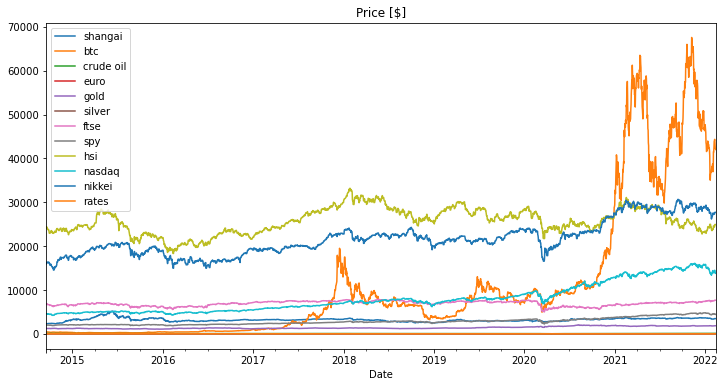

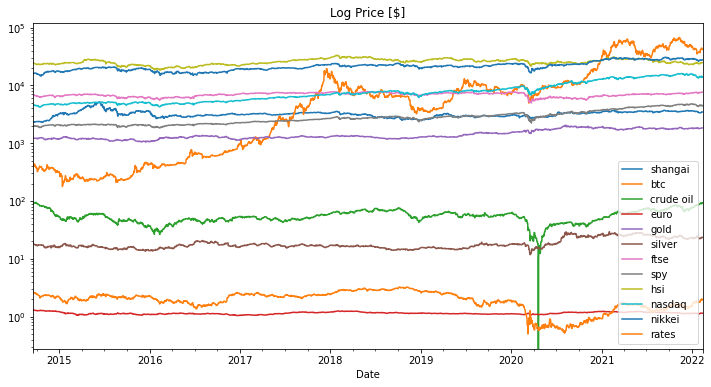

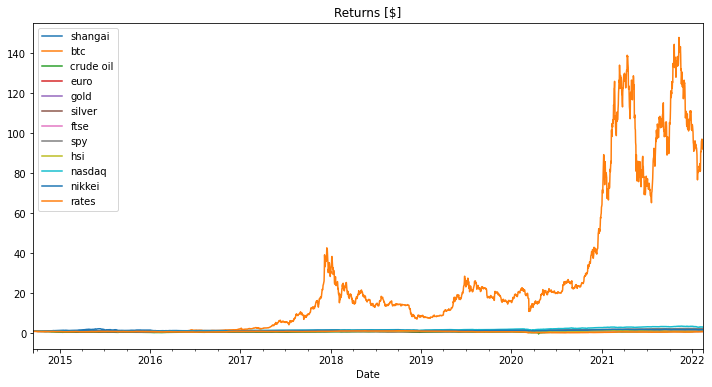

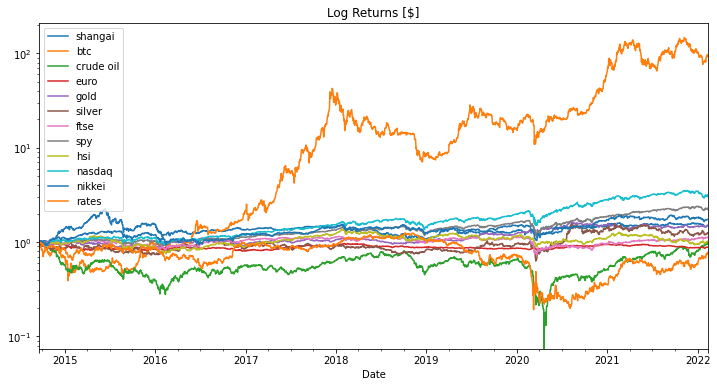

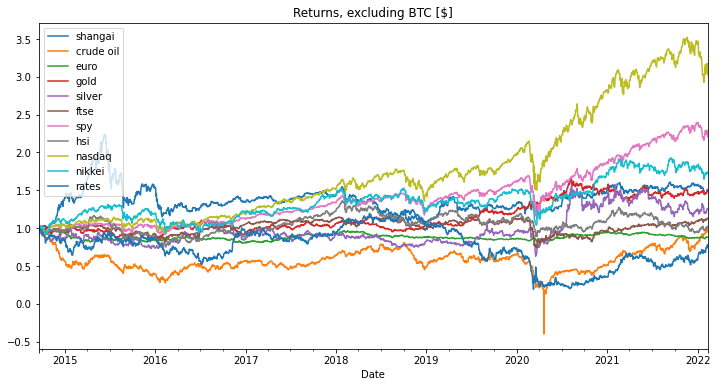

In [7]:
close = close[close.btc.notnull()]
returns = close.pct_change(1)
cumulative = (1 + returns).cumprod()

# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)

close.plot(figsize=(12,6),label='Price', title='Price [$]')
close.plot(figsize=(12,6),label='Price (log scale)', logy=True, title='Log Price [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns', title='Returns [$]')
cumulative.plot(figsize=(12,6),label='Cumulative Returns (log)', logy=True, title='Log Returns [$]')

cumulative.loc[:,cumulative.columns != 'btc'].plot(
    figsize=(12,6), label='Cumulative Returns', title='Returns, excluding BTC [$]')

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

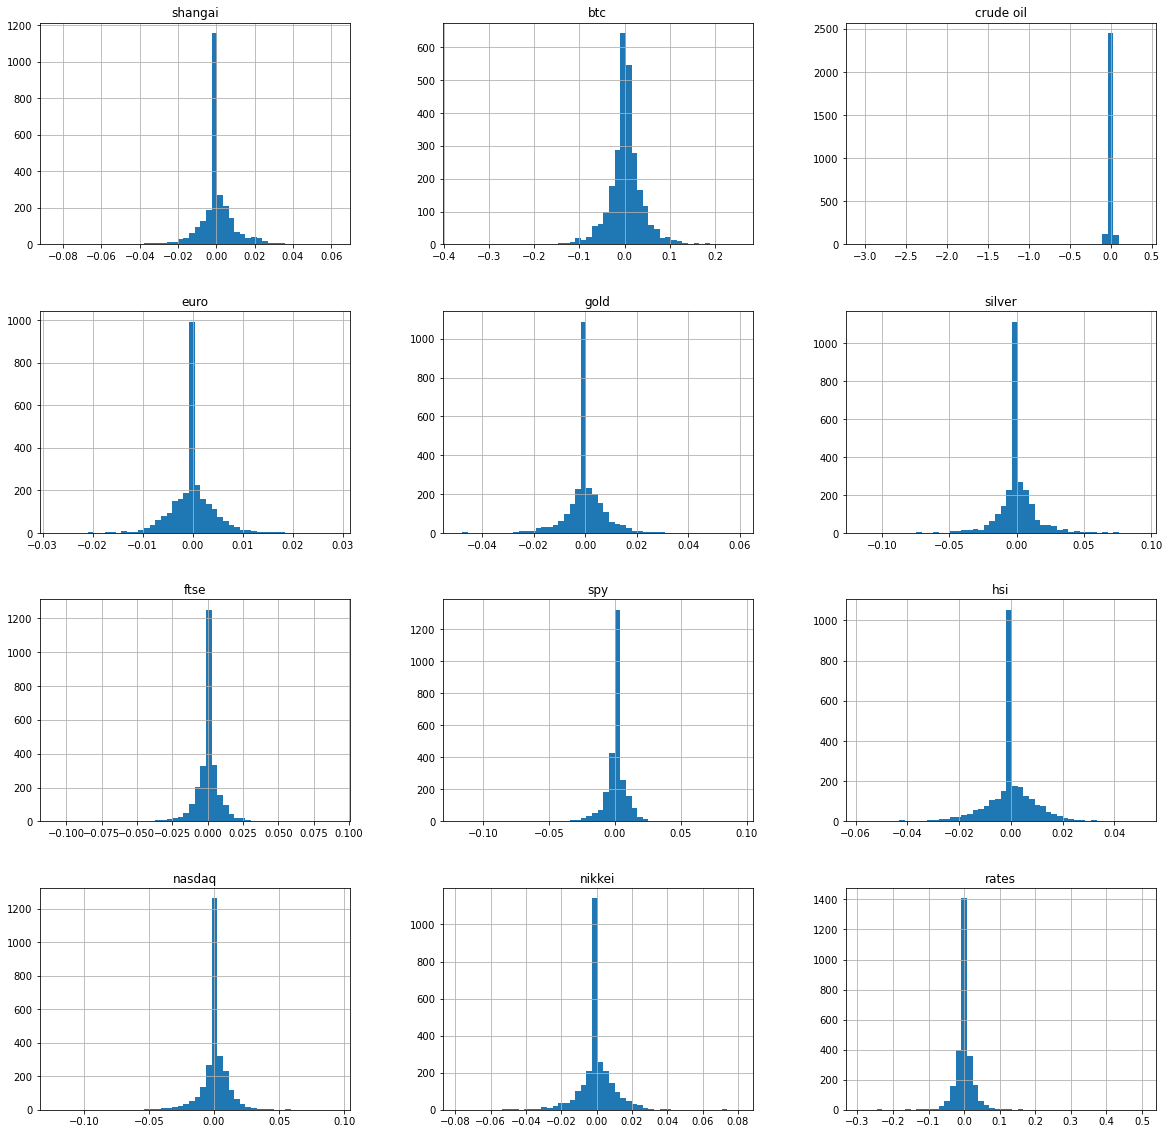

In [8]:
returns.hist(bins=50, figsize=(20,20))

As returns have a normal distribution, log normality will be possible with closing prices, but we will dive deeper
 into the dopic further ahead.

## Technical Indicator functions
Now we will calculate several indicators typically used in technical analysis of stock prices,
such as simple moving averages, the (stochastic) relative strength index and other statistical measures s.a.
the expanding standard deviation of Bitcoin price.

In [9]:
ta = tickers.btc

from data_utils.technical_analysis import transform_std, transform_ma, transform_rsi

### TODO for future improvement:
### Use vectorized functions for more speed.
ta = transform_std(transform_rsi(transform_ma(ta, ma_values[0], ma_values[1], ma_values[2])))
ta.tail()

/Users/rj/gitrepos/azure-ml-engineer/capstone/data_utils/technical_analysis.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA'+str(ma1)] = round(data['close'].rolling(ma1).mean(),0)
/Users/rj/gitrepos/azure-ml-engineer/capstone/data_utils/technical_analysis.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MA'+str(ma2)] = round(data['close'].rolling(ma2).mean(),0)
/Users/rj/gitrepos/azure-ml-engineer/capstone/data_utils/technical_analysis.py:17: SettingWithCopyWarning: 
A value is tryin

,open,high,low,close,adj close,volume,MA4,MA50,MA80,change,cum_change,k,d,num,div,rs,RSI,RSImin,RSImax,stochRSI,smoothK,smoothD,K1,D1,btc_std_dev,btc_mean,std_dif
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-09,44096.703125,44727.800781,43232.968750,44338.796875,44338.796875,2.324589e+10,43677.0,42694.0,46001.0,0.004995,96.950578,0.004995,0.000000,0.017324,0.004573,3.788377,79.116099,34.746872,79.116099,100.000000,100.00,99.88,100.00,99.75,16029.640999,11209.598956,28309.155876
2022-02-10,44347.800781,45661.171875,43402.808594,43565.113281,43565.113281,3.214205e+10,43966.0,42592.0,45842.0,-0.017449,95.258852,0.000000,0.017449,0.015015,0.006290,2.387086,70.476100,36.668575,79.116099,79.645457,93.22,97.74,100.00,99.88,16038.749616,11221.564752,27526.363665
2022-02-11,43571.128906,43810.832031,42114.539062,42407.937500,42407.937500,2.695493e+10,43608.0,42425.0,45652.0,-0.026562,92.728588,0.000000,0.026562,0.013013,0.008993,1.446994,59.133527,36.668575,79.116099,52.924059,77.52,90.25,93.22,97.74,16046.990627,11233.093910,26360.946873
2022-02-12,42412.300781,42992.550781,41852.574219,42244.468750,42244.468750,1.815239e+10,43139.0,42253.0,45477.0,-0.003855,92.371150,0.000000,0.003855,0.011278,0.008308,1.357476,57.581750,36.668575,79.116099,49.268303,60.61,77.12,77.52,90.25,16055.096055,11244.554138,26189.372695
2022-02-13,42180.785156,42678.355469,42028.769531,42028.769531,42028.769531,1.480709e+10,42562.0,42085.0,45286.0,-0.005106,91.899505,0.000000,0.005106,0.009774,0.007881,1.240209,55.361299,36.668575,79.116099,44.037255,48.74,62.29,60.61,77.12,16063.029994,11255.926216,25965.739537


In [10]:
# selection of technical indicators to feed the model
ta = ta[['open', 'high', 'low', 'close',
           f'MA{ma_values[0]}',f'MA{ma_values[1]}', f'MA{ma_values[2]}',
           'stochRSI', 'RSI','btc_std_dev','std_dif']].fillna(method='bfill')

### Exploring volume data

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>],
       [<AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>],
       [<AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>]], dtype=object)

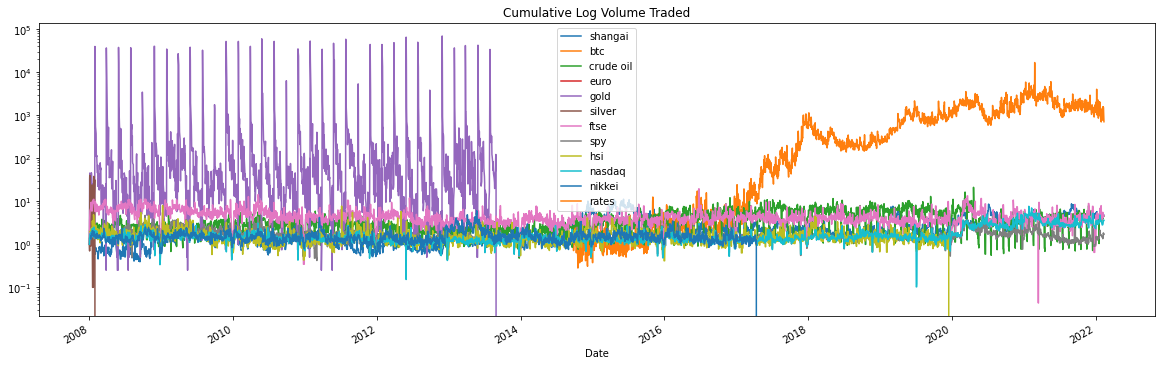

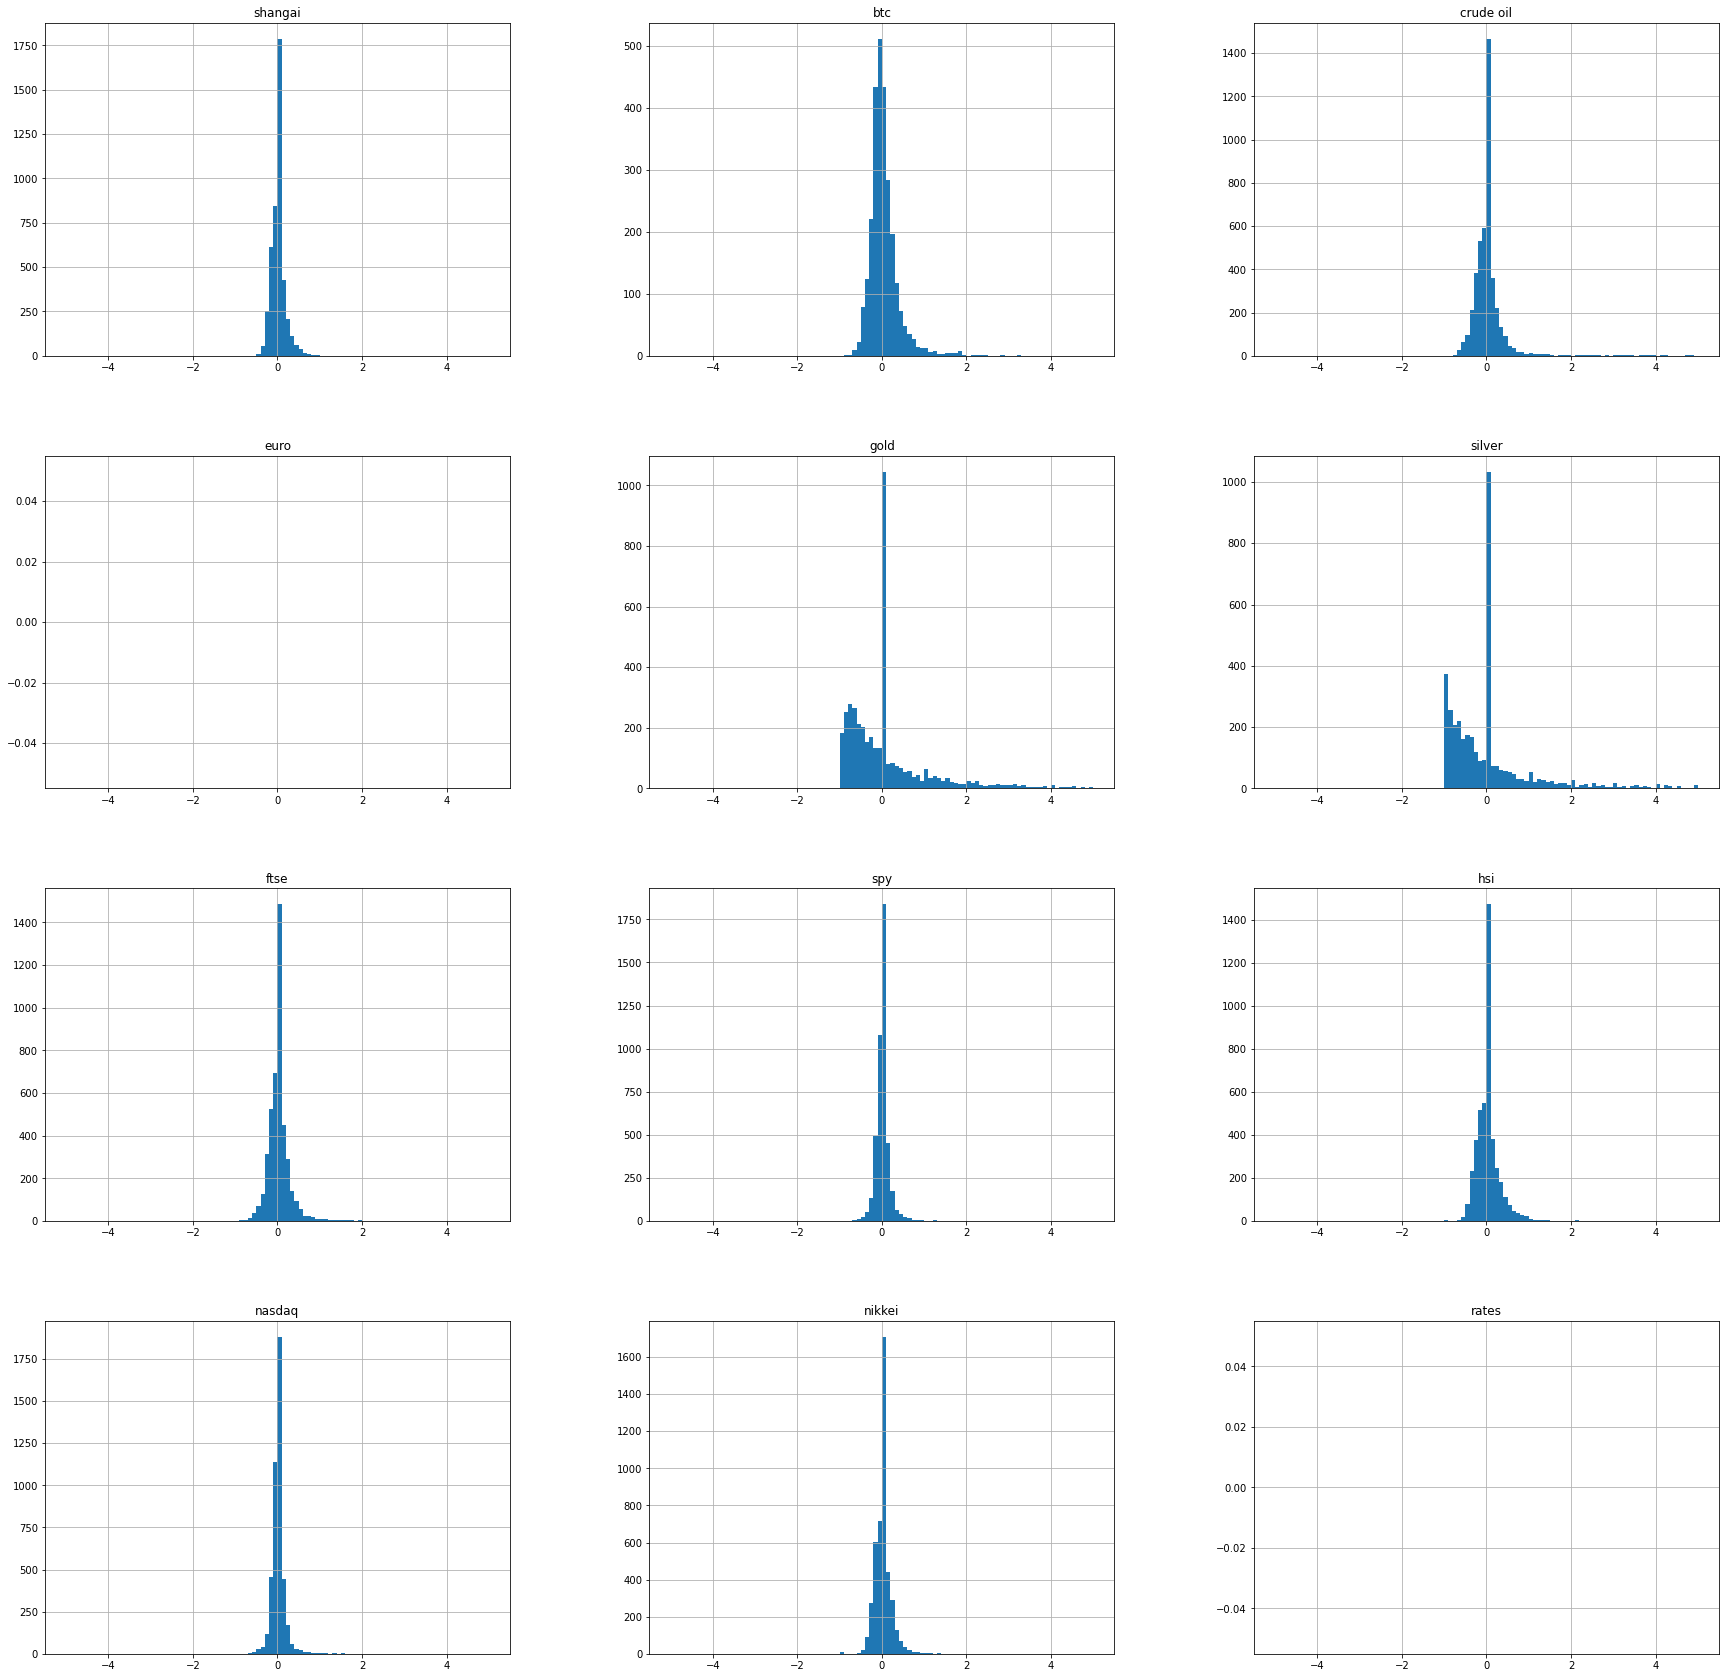

In [11]:
# volume.plot(logy=True, figsize=(20,6))
v_returns = volume.pct_change(1)
v_cumulative = (1+v_returns).cumprod()
v_cumulative.plot(logy=True, figsize=(20,6), title="Cumulative Log Volume Traded")
v_returns.hist(bins=100, figsize=(30,30), range=[-5, 5])

Ok volume data seems really interesting. However, gold and silver are skewed.
We also lack complete data of M2 money supply 'volume(?)' from 2014 onwards.

For the purpose of this capstone project, we will avoid including rates and the EUR/USD pair.

In [12]:
volume.drop(columns=['rates', 'euro'], inplace=True)
volume.columns

Index(['shangai', 'btc', 'crude oil', 'gold', 'silver', 'ftse', 'spy', 'hsi',
       'nasdaq', 'nikkei'],
      dtype='object')

In [13]:
volume.rename(columns = lambda x: "vol_" + x, inplace=True)
# volume.tail()

In [14]:
volume.describe()

,vol_shangai,vol_btc,vol_crude oil,vol_gold,vol_silver,vol_ftse,vol_spy,vol_hsi,vol_nasdaq,vol_nikkei
count,4457.000000,2.707000e+03,4.459000e+03,4459.000000,4459.000000,4.459000e+03,4.459000e+03,4.457000e+03,4.459000e+03,4.455000e+03
mean,192978.887144,1.468730e+10,4.146213e+05,5718.154743,1781.450325,8.573174e+08,3.991736e+09,1.893068e+09,2.444681e+09,1.216412e+08
std,127512.874683,2.003482e+10,2.122014e+05,30243.859580,9845.219851,3.379853e+08,1.174233e+09,7.446980e+08,1.169184e+09,5.413224e+07
min,30400.000000,5.914570e+06,4.851600e+04,0.000000,0.000000,8.378200e+06,1.025000e+09,0.000000e+00,1.494100e+08,0.000000e+00
25%,102400.000000,7.933630e+07,2.598210e+05,41.000000,8.000000,6.586600e+08,3.274995e+09,1.421452e+09,1.792335e+09,7.870000e+07
50%,155100.000000,5.071624e+09,3.615360e+05,141.000000,42.000000,7.868452e+08,3.710810e+09,1.739169e+09,2.034030e+09,1.179000e+08
75%,248400.000000,2.457629e+10,5.460110e+05,474.000000,153.500000,9.736804e+08,4.436410e+09,2.172201e+09,2.490395e+09,1.498000e+08
max,857100.000000,3.509679e+11,2.288230e+06,386334.000000,170297.000000,3.761301e+09,1.145623e+10,9.799120e+09,1.110216e+10,5.952000e+08


The problem with using volume data, seems that it is that not all instruments have it available,
plus we are not sure whether this is on the same measure value (USD). For this we will only take BTC.

### Fundamental Bitcoin data

Fundamental Bitcoin's blockchain data will also be included, such as hashrate, mining difficulty,
(daily) number of transactions and cost per transaction.

In [15]:
import quandl
import os

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

quandl_key = os.getenv("QUANDLKEY")
quandl.ApiConfig.api_key = quandl_key # (insert if available, else there is a ratelimit)

In [16]:
# print('This is your key!', quandl_key)

In [17]:

# btc mining is an interesting source, but free data has not the same quality ;)

# btcmining = quandl.get('BITCOINWATCH/MINING') # total btc and marketcap, bad quality data
# btcmining.fillna(method='ffill').plot(legend=None, logy=True)

btc_hrate = quandl.get('BCHAIN/HRATE') # hashrate
btc_diff = quandl.get('BCHAIN/DIFF') # difficulty
btc_ntrat = quandl.get('BCHAIN/NTRAT') # number of transactions
btc_cptra = quandl.get('BCHAIN/CPTRA') # cost per transaction


# m2 = quandl.get("FED/M2_N_WM") # unfortunately M2 money supply free data does not meet quality standards
# m2.rename({"Value":"M2"})

# fundamentals.fillna(method='ffill')

### Joining the data into a single DataFrame

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-09,3479.949951,44338.796875,89.660004,1.142126,1835.199951,23.336000,7643.399902,4587.180176,24829.990234,14490.370117,27579.869141,1.929,44096.703125,44727.800781,43232.968750,44338.796875,43677.0,42694.0,46001.0,100.000000,79.116099,16029.640999,28309.155876,2.324589e+10,1.857510e+08,2.669053e+13,709198351.0,149.147924
2022-02-10,3485.909912,43565.113281,89.879997,1.142152,1836.199951,23.518999,7672.399902,4504.080078,24924.349609,14185.639648,27696.080078,2.031,44347.800781,45661.171875,43402.808594,43565.113281,43966.0,42592.0,45842.0,79.645457,70.476100,16038.749616,27526.363665,3.214205e+10,1.950386e+08,2.669053e+13,709464092.0,159.608626
2022-02-11,3462.949951,42407.937500,93.099998,1.141553,1840.800049,23.365999,7661.000000,4418.640137,24906.660156,13791.150391,27696.080078,1.955,43571.128906,43810.832031,42114.539062,42407.937500,43608.0,42425.0,45652.0,52.924059,59.133527,16046.990627,26360.946873,2.695493e+10,1.884046e+08,2.669053e+13,709726725.0,152.760141
2022-02-12,3462.949951,42244.468750,93.099998,1.141553,1840.800049,23.365999,7661.000000,4418.640137,24906.660156,13791.150391,27696.080078,1.955,42412.300781,42992.550781,41852.574219,42244.468750,43139.0,42253.0,45477.0,49.268303,57.581750,16055.096055,26189.372695,1.815239e+10,2.481103e+08,2.669053e+13,709983445.0,219.222622
2022-02-13,3462.949951,42028.769531,93.099998,1.141553,1840.800049,23.365999,7661.000000,4418.640137,24906.660156,13791.150391,27696.080078,1.955,42180.785156,42678.355469,42028.769531,42028.769531,42562.0,42085.0,45286.0,44.037255,55.361299,16063.029994,25965.739537,1.480709e+10,NaN,NaN,NaN,NaN


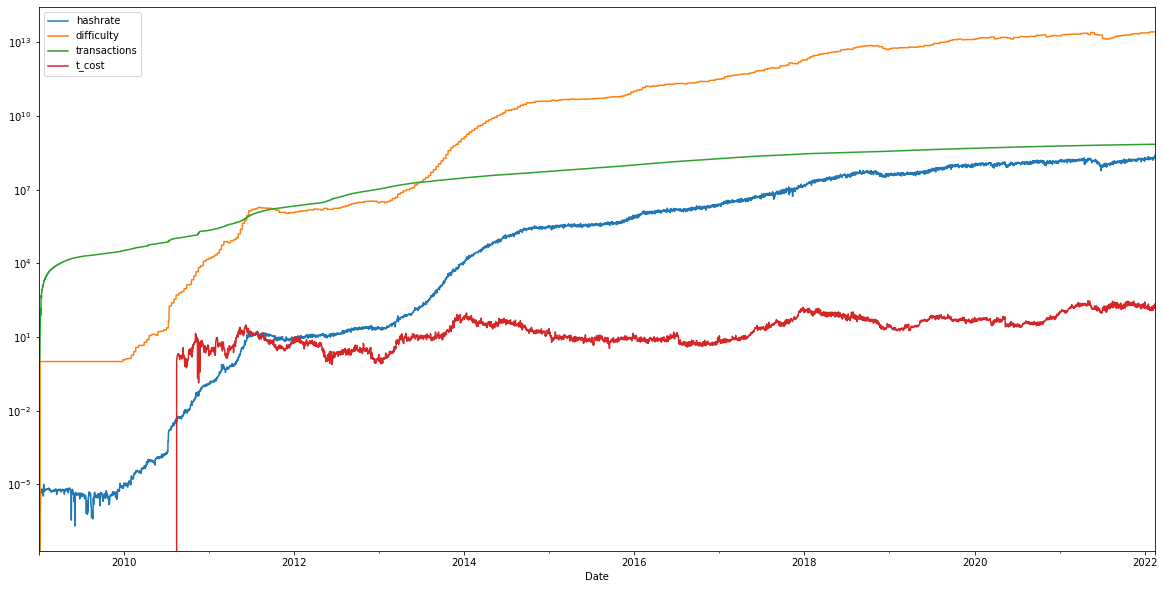

In [18]:
df = pd.concat([close, ta], axis=1)
df = pd.concat([df, volume['vol_btc']], axis=1)

fundamentals = pd.concat([btc_hrate, btc_diff, btc_ntrat, btc_cptra], axis=1)
fundamentals.columns = ['hashrate','difficulty','transactions','t_cost'] #, 'm2']
fundamentals.plot(figsize=(20,10), logy=True)
df = pd.concat([df, fundamentals], axis=1)
# df.rename(columns={'btc':'btc_cumulative'}, inplace=True)

df.tail()

## Labelling buy, sell and no-trade signals
Following our objective, we will need to predict whether prices are going to go up or down.
For this, the condition for the labels will be that if price goes up by more than a certain confidence level it's a buy,
 down a certain confidence level or less a sell, and values in between labelled as no-trade zone.

We will need to shift by one this values to become the predicted labels of our trained model.

In [19]:
returns.btc.describe()

count    2706.000000
mean        0.002433
std         0.038836
min        -0.371695
25%        -0.013134
50%         0.001996
75%         0.018258
max         0.252472
Name: btc, dtype: float64

Given the confidence intervals above, I will take the top 75% interval as buy label (1),
the lowest 25% for the sell label (2), and the values in between as no-trade (0).
The objective of the classification problem will be to **predict the next day's label to give a trading signal**.

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   1.,
          1.,   2.,   0.,   2.,   1.,   4.,   2.,   1.,   7.,   7.,  13.,
          5.,   9.,   9.,  15.,  18.,  39.,  30.,  33.,  45.,  55.,  78.,
         99., 124., 162., 283., 360., 308., 239., 149., 128.,  92.,  74.,
         67.,  50.,  35.,  24.,  24.,  22.,  13.,   8.,   7.,  16.,   8.,
          7.,   7.,   3.,   3.,   1.,   0.,   2.,   3.,   0.,   0.,   1.,
          2.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.]),
 array([-0.37169539, -0.36545371, -0.35921204, -0.35297037, -0.3467287 ,
        -0.34048703, -0.33424536, -0.32800369, -0.32176202, -0.31552035,
        -0.30927868, -0.30303701, -0.29679534, -0.29055367, -0.28431199,
        -0.27807032, -0.27182865, -0.26558698, -0.25934531, -0.25310364,
        -0.24686197, -0.24

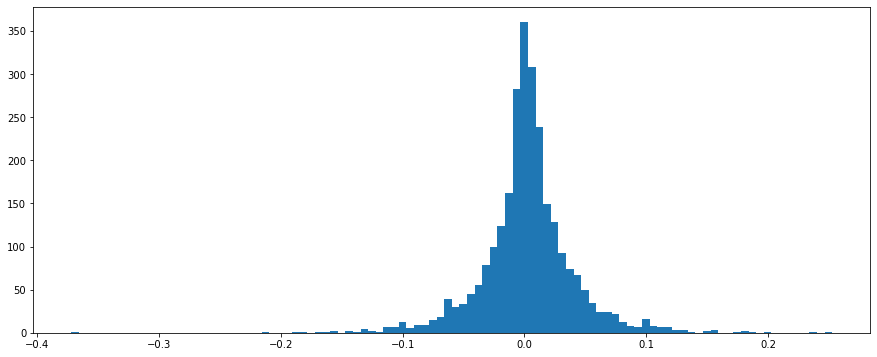

In [20]:
plt.figure(figsize = (15,6))
plt.hist(returns.btc, bins=100)

In [21]:
print(log_cumulative.columns)
# log_cumulative.tail()

Index(['shangai', 'btc', 'crude oil', 'euro', 'gold', 'silver', 'ftse', 'spy',
       'hsi', 'nasdaq', 'nikkei', 'rates'],
      dtype='object')


### Creating labels

In [22]:
labels = pd.DataFrame(returns.btc)
labels['y_returns'] = returns.btc
labels.drop(columns=['btc'], inplace=True)
labels['y_close'] = ta.close

In [23]:
print(labels.columns)
labels.tail()

Index(['y_returns', 'y_close'], dtype='object')


,y_returns,y_close
Date,,
2022-02-09,0.004995,44338.796875
2022-02-10,-0.017449,43565.113281
2022-02-11,-0.026562,42407.937500
2022-02-12,-0.003855,42244.468750
2022-02-13,-0.005106,42028.769531


In [24]:
buy_cond = labels.y_returns > labels.y_returns.describe().loc['75%'] # returns.btc.describe()['75%']
sell_cond = labels.y_returns <  labels.y_returns.describe().loc['25%'] # -0.013636 # returns.btc.describe()['25%']

In [25]:
labels['y_c'] = 0
labels['y_c'] = labels['y_c'].mask(buy_cond, 1)
labels['y_c'] = labels['y_c'].mask(sell_cond, -1)
labels.head()

labels['y_returns_shift'] = labels['y_returns'].shift(-1)

# Finally join our labels with the consolidated DataFrame
df = pd.concat([df,labels], axis=1)

### Data cleaning
I'll consider the minimal available records as starting point and select the training data.
Dates afterwards will be test data. We will also get rid of NA values that aren't useful for our analysis.

In [26]:
# row data cleaning
print('df ', df.shape)
print(df.index.min())

print('labels ', labels.shape)
print(labels.index.min())

df  (5055, 32)
2007-12-31 00:00:00
labels  (2707, 4)
2014-09-17 00:00:00


In [27]:
# Take the least available value
df = df[df.index.min():].dropna()
df.describe()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift
count,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2705.000000,2.705000e+03,2.705000e+03,2.705000e+03,2.705000e+03,2705.000000,2705.000000,2705.000000,2705.00000,2705.000000
mean,3189.332714,11248.542019,54.580407,1.143444,1411.792717,18.210331,6903.124951,2817.147283,25708.015083,7979.849154,21586.943548,1.964148,11234.868212,11537.554473,10900.831781,11248.542019,11225.197412,10882.263586,10631.330129,52.409259,55.100393,3456.860094,7797.885259,1.469268e+10,5.377340e+07,7.426469e+12,3.379182e+08,53.948002,0.002436,11248.542019,0.00000,0.002461
std,398.838401,16056.724045,13.363926,0.049533,257.084227,3.803471,544.357574,762.742916,2897.407783,3266.945069,3802.353774,0.641676,16051.290270,16483.577205,15553.400029,16056.724045,16030.460358,15662.765490,15336.621396,35.097289,17.881607,4088.249120,12457.001531,2.004024e+10,5.870610e+07,8.108132e+12,2.056913e+08,58.088087,0.038842,16056.724045,0.70763,0.038816
min,2289.865967,178.102997,-37.630001,1.039047,1050.800049,11.735000,4993.899902,1829.079956,18319.580078,4213.660156,14532.509766,0.499000,176.897003,211.731003,171.509995,178.102997,199.000000,232.000000,234.000000,0.000000,0.000000,19.012574,2.518605,5.914570e+06,2.205477e+05,2.982973e+10,4.694520e+07,3.442916,-0.371695,178.102997,-1.00000,-0.371695
25%,2930.149902,606.590027,45.950001,1.109078,1222.500000,15.695000,6529.200195,2129.899902,23654.300781,5147.120117,19083.099609,1.576000,606.283020,609.054993,602.242004,606.590027,606.000000,596.000000,594.000000,20.909914,42.359290,120.223694,373.530778,7.966080e+07,1.547311e+06,2.133989e+11,1.447700e+08,9.288600,-0.013140,606.590027,-1.00000,-0.013115
50%,3159.166016,6305.799805,53.250000,1.133414,1294.699951,16.912001,7026.899902,2691.250000,25708.039062,7223.689941,21181.640625,2.048000,6294.229980,6423.250000,6204.220215,6305.799805,6341.000000,6338.000000,5971.000000,52.875662,54.210297,3623.059840,2788.417309,5.071624e+09,3.368211e+07,4.306950e+12,3.198379e+08,33.968112,0.001999,6305.799805,0.00000,0.001999
75%,3404.873047,10400.915039,63.080002,1.179380,1674.500000,18.761999,7337.799805,3140.979980,27990.210938,9185.099609,23204.759766,2.389000,10402.042969,10680.507812,10189.744141,10400.915039,10428.000000,10386.000000,10148.000000,85.868992,68.342458,3992.815106,6606.784768,2.458267e+10,1.068612e+08,1.477637e+13,5.186160e+08,66.516249,0.018261,10400.915039,1.00000,0.018261
max,5166.350098,67566.828125,94.570000,1.292006,2051.500000,29.398001,7877.500000,4796.560059,33154.121094,16057.440430,30670.099609,3.234000,67549.734375,68789.625000,66382.062500,67566.828125,66121.000000,60802.000000,56971.000000,100.000000,98.422025,16055.096055,53525.381373,3.509679e+11,2.481103e+08,2.669053e+13,7.099834e+08,300.310549,0.252472,67566.828125,1.00000,0.252472


In [28]:
df.head()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-18,2315.927979,424.440002,93.070000,1.285000,1225.699951,18.452000,6819.299805,2011.359985,24168.720703,4593.430176,16067.570312,2.629,456.859985,456.859985,413.104004,424.440002,421.0,373.0,373.0,63.913817,0.000000,23.259579,401.180423,34483200.0,240220.740405,2.982973e+10,46945196.0,29.138967,-0.071926,424.440002,-1.0,-0.069843
2014-09-19,2329.450928,394.795990,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,424.102997,427.834991,384.532013,394.795990,421.0,373.0,373.0,63.913817,0.000000,31.283084,363.512906,37919700.0,240220.740405,2.982973e+10,47136557.0,28.902143,-0.069843,394.795990,-1.0,0.035735
2014-09-20,2329.450928,408.903992,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,394.673004,423.295990,389.882996,408.903992,421.0,373.0,373.0,63.913817,23.777418,26.860222,382.043769,36863600.0,259497.713401,2.982973e+10,47199708.0,28.205716,0.035735,408.903992,1.0,-0.024659
2014-09-21,2329.450928,398.821014,92.410004,1.292006,1215.300049,17.781000,6837.899902,2010.400024,24306.160156,4579.790039,16321.169922,2.587,408.084991,412.425995,393.181000,398.821014,407.0,373.0,373.0,63.913817,19.992515,25.353136,373.467879,26580100.0,232806.520022,2.982973e+10,47156242.0,29.910568,-0.024659,398.821014,-1.0,0.008352
2014-09-22,2289.865967,402.152008,91.519997,1.284142,1216.800049,17.698999,6773.600098,1994.290039,23955.490234,4527.689941,16205.900391,2.566,399.100006,406.915985,397.130005,402.152008,401.0,373.0,373.0,63.913817,24.678341,23.457930,378.694078,24127600.0,232806.520022,2.982973e+10,47339374.0,22.511639,0.008352,402.152008,0.0,0.083647


In [29]:
# Fill NAs
df.fillna(method='ffill', inplace=True)

In [30]:
df['y_c_shift'] = df['y_c'].shift(-1)
df['y_close_shift'] = df['y_close'].shift(-1)

df = df[:-2]
df.tail()

,shangai,btc,crude oil,euro,gold,silver,ftse,spy,hsi,nasdaq,nikkei,rates,open,high,low,close,MA4,MA50,MA80,stochRSI,RSI,btc_std_dev,std_dif,vol_btc,hashrate,difficulty,transactions,t_cost,y_returns,y_close,y_c,y_returns_shift,y_c_shift,y_close_shift
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-06,3361.439941,42412.433594,92.309998,1.143576,1806.599976,22.475000,7516.399902,4500.529785,24573.289062,14098.009766,27439.990234,1.930,41441.121094,42500.785156,41244.906250,42412.433594,40627.0,42898.0,46554.0,100.000000,73.298852,16000.976605,26411.456989,1.614210e+10,2.069797e+08,2.669053e+13,708441033.0,186.963586,0.023437,42412.433594,1.0,0.033666,1.0,43840.285156
2022-02-07,3429.580078,43840.285156,91.320000,1.145515,1820.599976,23.076000,7573.500000,4483.870117,24579.550781,14015.669922,27248.869141,1.916,42406.781250,44401.863281,41748.156250,43840.285156,42299.0,42841.0,46375.0,100.000000,77.690662,16010.356634,27829.928522,2.864186e+10,1.804439e+08,2.669053e+13,708659645.0,142.311162,0.033666,43840.285156,1.0,0.006345,0.0,44118.445312
2022-02-08,3452.629883,44118.445312,89.360001,1.144296,1826.599976,23.195000,7567.100098,4521.540039,24329.490234,14194.450195,27284.519531,1.954,43854.652344,45293.867188,42807.835938,44118.445312,42953.0,42786.0,46181.0,100.000000,78.461064,16019.925849,28098.519464,3.307940e+10,2.043262e+08,2.669053e+13,708921648.0,153.836213,0.006345,44118.445312,0.0,0.004995,0.0,44338.796875
2022-02-09,3479.949951,44338.796875,89.660004,1.142126,1835.199951,23.336000,7643.399902,4587.180176,24829.990234,14490.370117,27579.869141,1.929,44096.703125,44727.800781,43232.968750,44338.796875,43677.0,42694.0,46001.0,100.000000,79.116099,16029.640999,28309.155876,2.324589e+10,1.857510e+08,2.669053e+13,709198351.0,149.147924,0.004995,44338.796875,0.0,-0.017449,-1.0,43565.113281
2022-02-10,3485.909912,43565.113281,89.879997,1.142152,1836.199951,23.518999,7672.399902,4504.080078,24924.349609,14185.639648,27696.080078,2.031,44347.800781,45661.171875,43402.808594,43565.113281,43966.0,42592.0,45842.0,79.645457,70.476100,16038.749616,27526.363665,3.214205e+10,1.950386e+08,2.669053e+13,709464092.0,159.608626,-0.017449,43565.113281,-1.0,-0.026562,-1.0,42407.937500


## Data transformations

In order to make try our best so that no feature becomes more important in the dataset than the others,
we will create functions to normalize these and bring them back to the dataset's original state.
This will be used later before saving the feed-in dataset.

We will be using log cumulative returns for price features, and normalize the oscillating factors (i.e. RSI)

<AxesSubplot:title={'center':'Cumulative Returns [$]'}, xlabel='Date'>

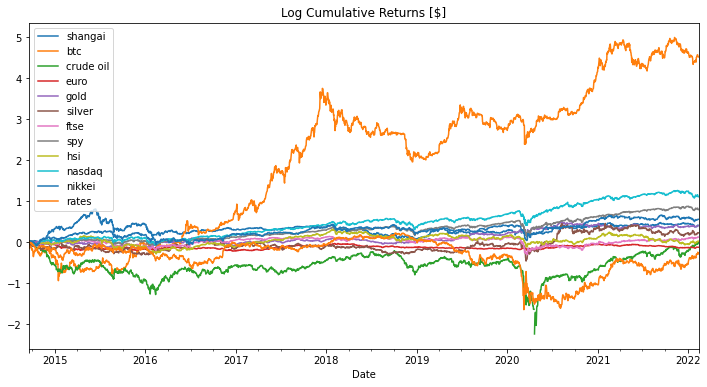

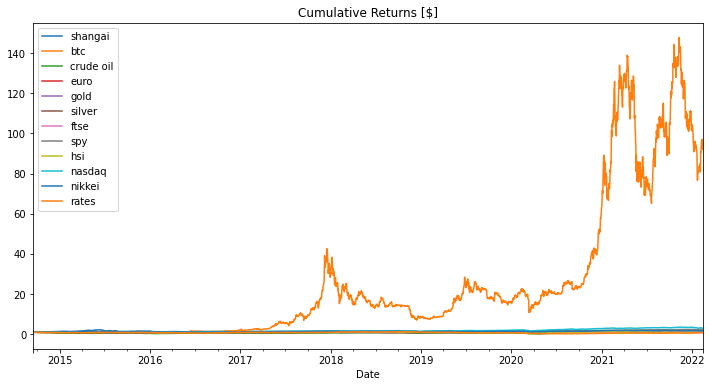

In [31]:
# For the above, it makes sense to take the logarithm
log_cumulative = np.log(cumulative)
# We can observe that log cumulative returns are reversible. This is useful for predicting price.
log_cumulative.loc[:,:].plot(
    figsize=(12,6), title='Log Cumulative Returns [$]')

np.exp(log_cumulative).plot(figsize=(12,6), title='Cumulative Returns [$]')

Here we will apply the mentioned transformation to features, in a sense que can
revert these to previous values. We will use normalization on log_cumulative (easing a lognormal step),
and normalize and standardize oscillators.

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

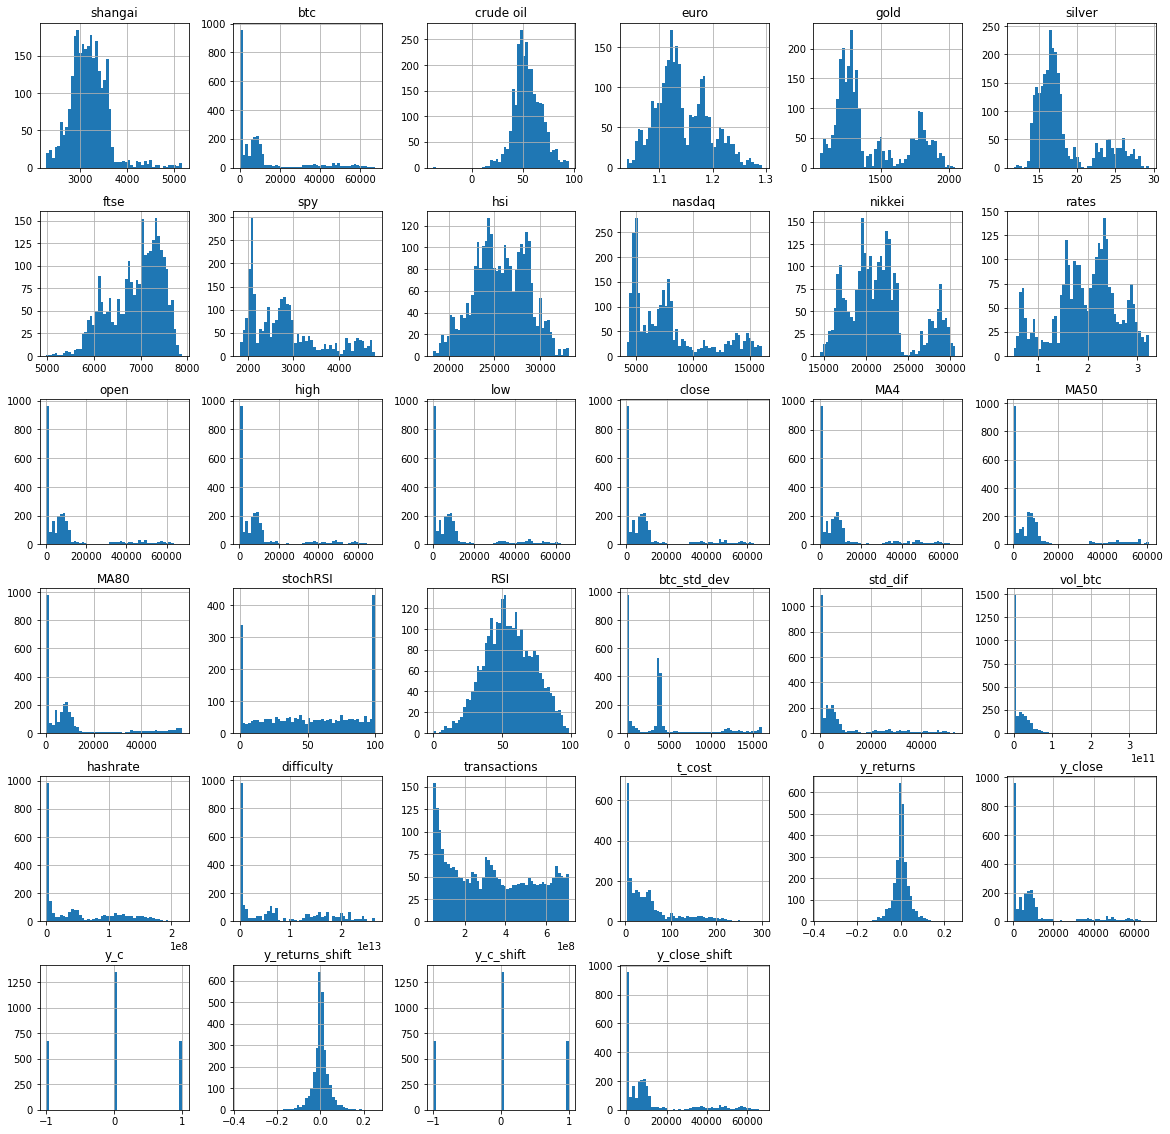

In [32]:
# Have a look at the data
df.hist(bins=50, figsize=(20,20))

array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'close'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>],
       [<AxesSubplot:title={'center':'MA80'}>,
        <AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'

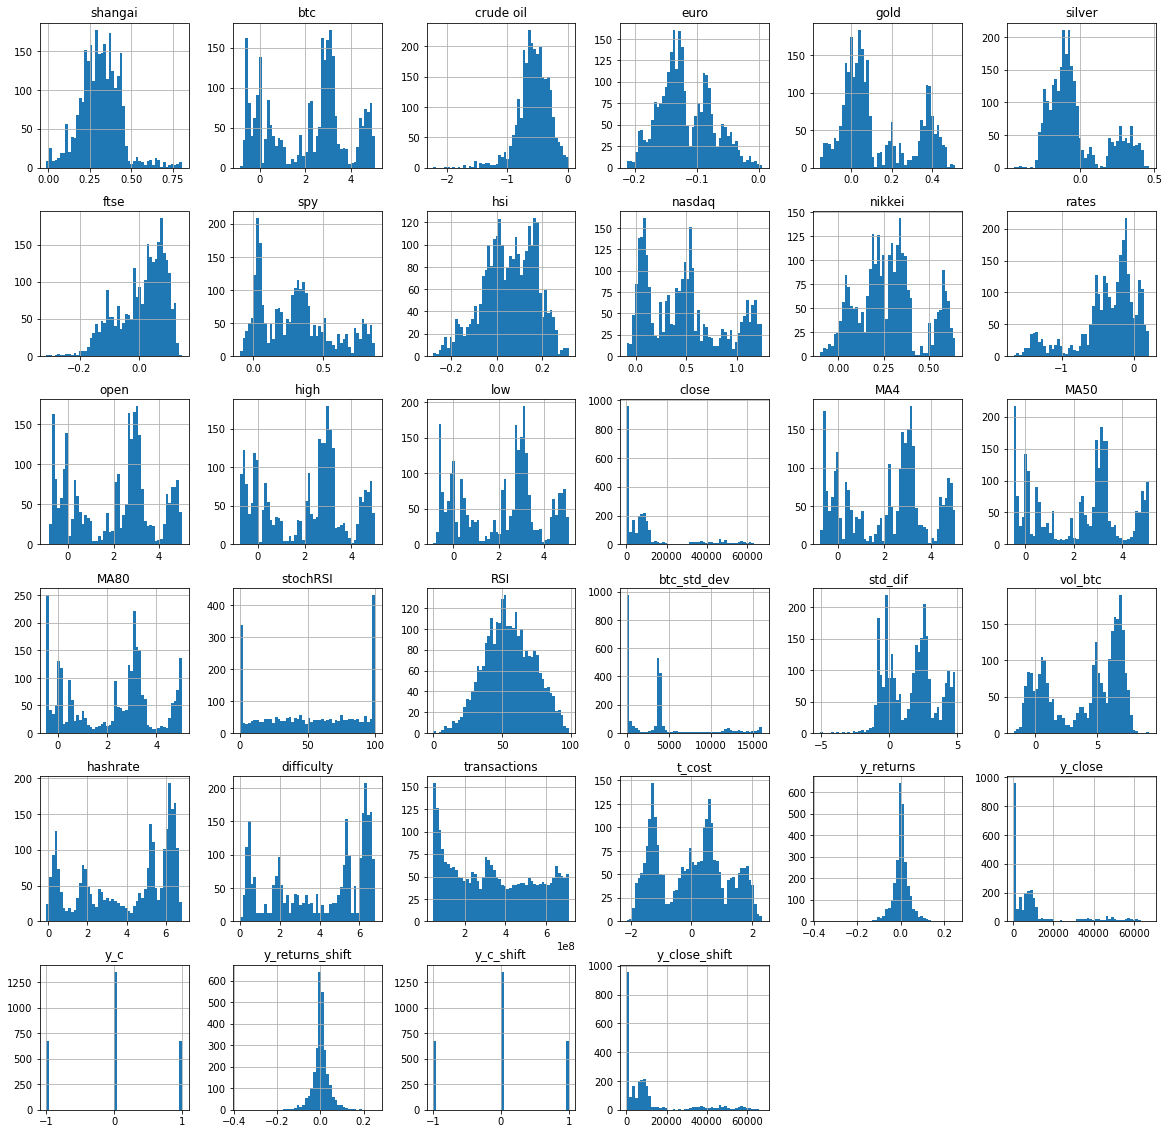

In [33]:
# Take log cumulative returns of skewed features
cum_cols = list(close.columns) + ['open', 'high','low',
            'std_dif', f'MA{ma_values[0]}', f'MA{ma_values[1]}', f'MA{ma_values[2]}',
            'hashrate', 'difficulty', 't_cost', 'vol_btc']

# We will do transformations on a copy of the dataframe to preserve original data
ndf = df
ndf[cum_cols] = (1 + ndf[cum_cols].pct_change(1)).cumprod()
ndf[cum_cols] = np.log(ndf[cum_cols])

ndf.hist(bins=50, figsize=(20,20))

In [34]:
# Drop columns that are not needed anymore
drop_cols = ['close']

for x in drop_cols:
    if x in ndf.columns:
        ndf.drop(columns=x, inplace=True)

In [35]:
# Normalize what is needed
# norm_cols = ['']
# ndf[norm_cols], mindf, maxdf = min_max_scaler(ndf[norm_cols], log=False)

['shangai', 'btc', 'crude oil', 'euro', 'gold', 'silver', 'ftse', 'spy', 'hsi', 'nasdaq', 'nikkei', 'rates', 'open', 'high', 'low', 'MA4', 'MA50', 'MA80', 'stochRSI', 'RSI', 'btc_std_dev', 'std_dif', 'vol_btc', 'hashrate', 'difficulty', 'transactions', 't_cost', 'y_c']


array([[<AxesSubplot:title={'center':'shangai'}>,
        <AxesSubplot:title={'center':'btc'}>,
        <AxesSubplot:title={'center':'crude oil'}>,
        <AxesSubplot:title={'center':'euro'}>,
        <AxesSubplot:title={'center':'gold'}>,
        <AxesSubplot:title={'center':'silver'}>],
       [<AxesSubplot:title={'center':'ftse'}>,
        <AxesSubplot:title={'center':'spy'}>,
        <AxesSubplot:title={'center':'hsi'}>,
        <AxesSubplot:title={'center':'nasdaq'}>,
        <AxesSubplot:title={'center':'nikkei'}>,
        <AxesSubplot:title={'center':'rates'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'high'}>,
        <AxesSubplot:title={'center':'low'}>,
        <AxesSubplot:title={'center':'MA4'}>,
        <AxesSubplot:title={'center':'MA50'}>,
        <AxesSubplot:title={'center':'MA80'}>],
       [<AxesSubplot:title={'center':'stochRSI'}>,
        <AxesSubplot:title={'center':'RSI'}>,
        <AxesSubplot:title={'center':'btc_st

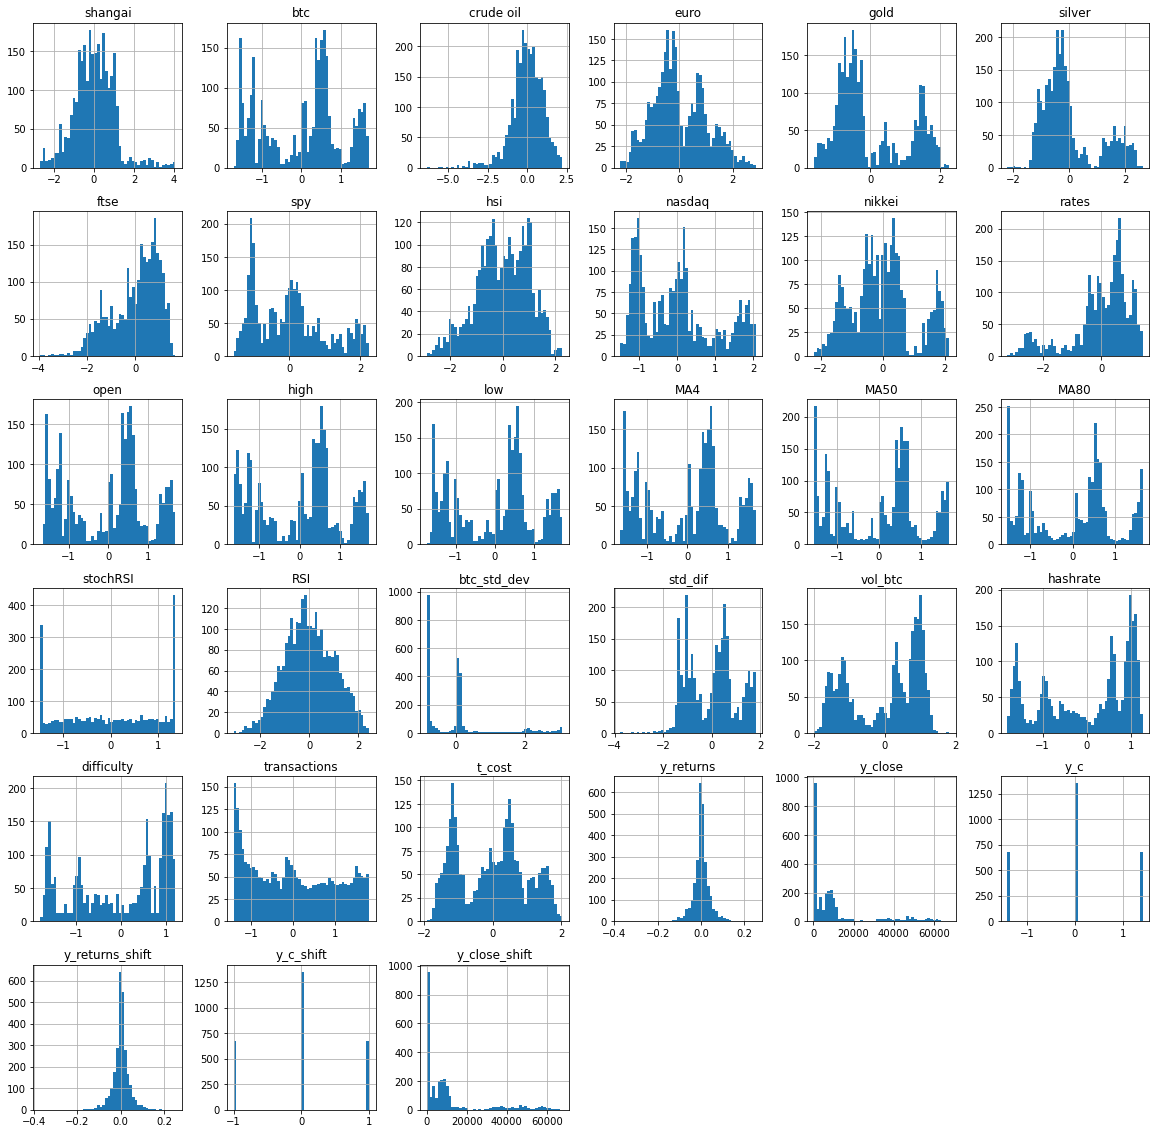

In [36]:
# Standardize what needs to be. In this case, the whole dataset, except labels
s_cols = list(ndf.columns)
non_s_cols = ['y_close', 'y_returns', 'y_c_shift', 'y_close_shift', 'y_returns_shift']

for x in non_s_cols:
    s_cols.remove(x)

print(s_cols)
ndf[s_cols], mean, std = standardizer(ndf[s_cols], log=False)

ndf.hist(bins=50, figsize=(20,20))

In [37]:
# ndf.tail()

Our features look much better now! Did not do any transformations on the labels.

## Are these features correlated?

In [38]:
# Correlation of BTC with features
cor_list = df.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(
#     # index=['btc', 'open', 'high', 'low',
#     # 'std_dif', 'MA4', 'y_close_shift', 'MA50', 't_cost',
#     # 'MA80', 'transactions', 'btc_std_dev',
#     # 'RSI', 'y_returns', 'y_returns_shift', 'stochRSI', 'y_close',
#     # 'y_returns', 'y_c_shift', 'difficulty', 'hashrate']
# )
print(cor_list)

btc                1.00
low                1.00
high               1.00
MA4                1.00
open               1.00
MA50               1.00
MA80               0.99
vol_btc            0.96
hashrate           0.95
difficulty         0.95
transactions       0.94
spy                0.94
nasdaq             0.94
t_cost             0.93
std_dif            0.92
nikkei             0.88
btc_std_dev        0.83
gold               0.80
y_close_shift      0.78
y_close            0.78
silver             0.60
hsi                0.58
euro               0.39
crude oil          0.33
ftse               0.31
shangai            0.07
y_returns          0.02
RSI                0.01
y_returns_shift   -0.00
y_c               -0.01
stochRSI          -0.01
y_c_shift         -0.03
rates             -0.33
Name: btc, dtype: float64


BTC price is *negatively correlated* to FED's interest rates, and very slightly to the target variables. It also seems
uncorrelated to the RSI and the shifted returns.

On the other hand, it is **strongly correlated** to its volume, other fundamentals seen above, as well as S&P and Nasdaq.

In [39]:
# Normalized correlation does not change, uncomment below to see
# cor_list = ndf.corr()['btc'].sort_values(ascending=False).round(2)
# cor_list.drop(index=['btc', 'open', 'high', 'low',
#     'std_dif', 'MA4', 'y_close_shift', 'MA50', 't_cost',
#     'MA80', 'transactions', 'btc_std_dev',
#     'RSI', 'y_pnl', 'y_returns', 'y_returns_shift' 'stochRSI',
#     'returns_label', 'y_c_shift', 'difficulty', 'hashrate', 'log_btc_cumulative'])

<AxesSubplot:>

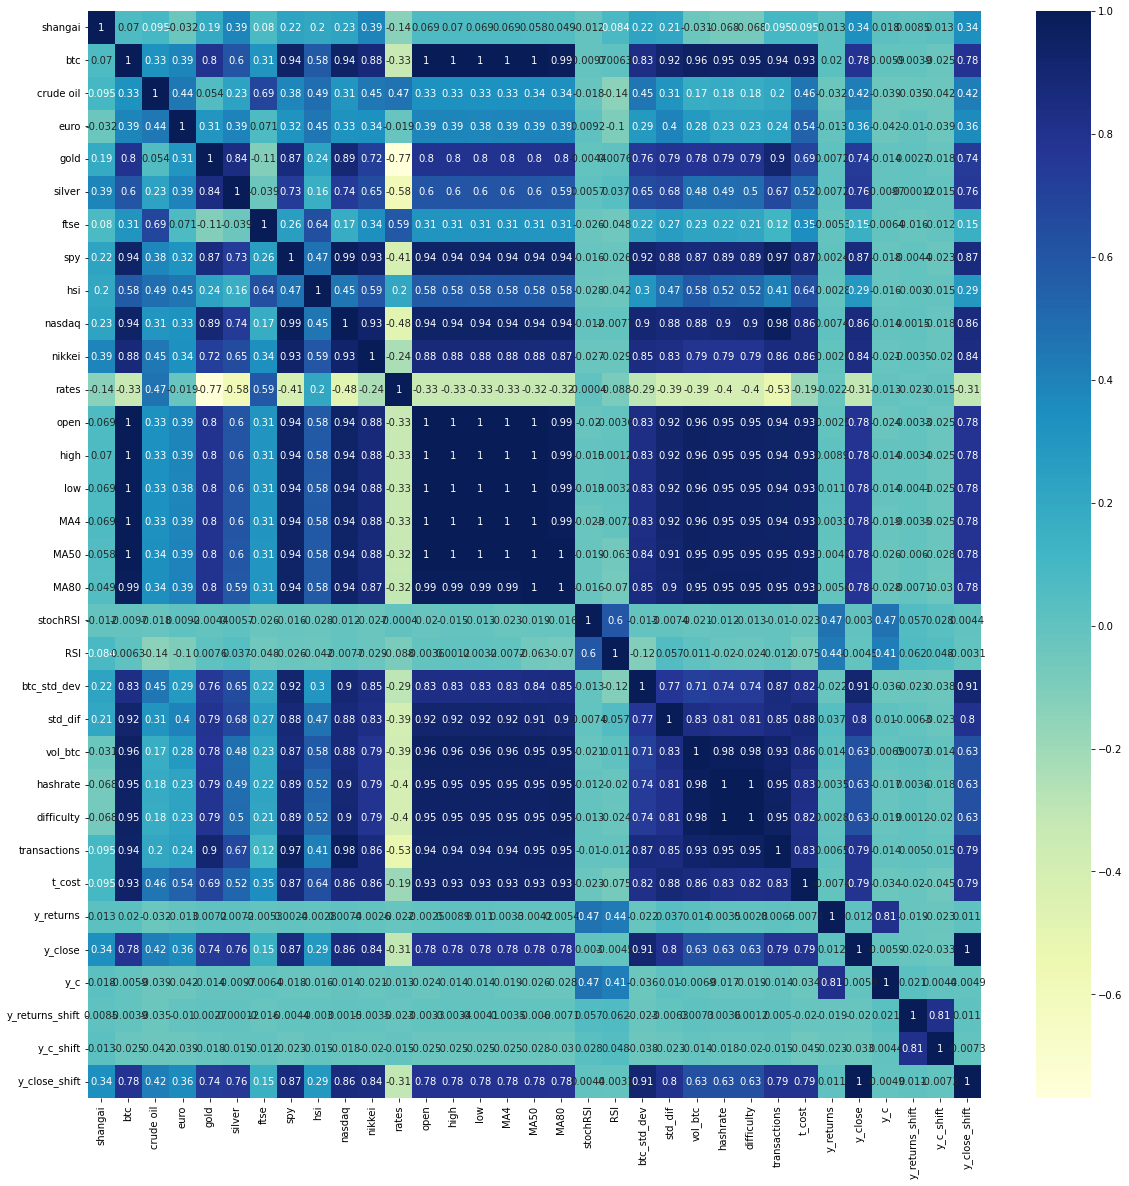

In [40]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(), 
        xticklabels=df.corr().columns,
        yticklabels=df.corr().columns, ax=ax,
            annot=True, 
            cmap="YlGnBu")

In [41]:
# Description of normalized features
# print(ndf.shape)
# ndf.describe()

Also interestingly, btc returns (`y_returns`) seem slightly negatively correlated with day-ahead returns.

### Saving the datasets

In [42]:
df_list = [df, ndf, mean, std]
df_path_list = ['data/df.csv', 'data/ndf.csv', 'data/mean.csv', 'data/std.csv']
for (x, y) in zip(df_list, df_path_list):
    x.to_csv(y)

# What comes next?
Ok so, we now have data we can work with! Now it's time to jump into AzureML Studio and go on with the project's
next steps:
- [**Training, tuning & deployment with AutoML**](2-automl.ipynb)
- [**Training & tuning with Hyperdrive**](3-hyperparameter_tuning.ipynb)
